In [162]:
import pandas as pd
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data0 = pd.read_csv("data/1019_SP.csv").dropna()
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data0.get("Date")
Date = pd.to_datetime(Date)
Close = data0.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")
dict = {"Date": Date,
        "close": Close, 
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,close,close_cl,close_ovx,close_gc,close_gvz
Date,,,,,
2019-12-13,3168.800049,60.070000,26.760000,1475.599976,10.39
2019-12-16,3191.449951,60.209999,26.510000,1475.000000,10.39
2019-12-17,3192.520020,60.939999,26.330000,1474.599976,10.03
2019-12-18,3191.139893,60.930000,26.770000,1472.599976,10.04
2019-12-19,3205.370117,61.220001,24.799999,1478.199951,10.39
2019-12-20,3221.219971,60.439999,25.540001,1474.699951,9.69
2019-12-23,3224.010010,60.520000,25.110001,1482.500000,10.56
2019-12-26,3239.909912,61.680000,24.080000,1509.300049,13.33
2019-12-27,3240.020020,61.720001,25.160000,1513.800049,12.32


In [ ]:
dataset = pd.DataFrame({
    'Close':df['close'],
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['close'],
})

feature_names = list(dataset.columns[:-1])

In [164]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 6)
after dropping NaN (2493, 6)


In [165]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
#dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000
mean,0.422965,0.527754,0.290049,0.353032,0.261824,0.422965
std,0.265162,0.249914,0.156572,0.213666,0.156178,0.265162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.161118,0.298108,0.187839,0.207304,0.142903,0.161118
50%,0.434046,0.514706,0.269117,0.289533,0.246540,0.434046
75%,0.636121,0.767556,0.375989,0.457453,0.347602,0.636121
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [166]:
from keras.utils import np_utils
#每張圖包含幾天的資料
time_period = 20
#預設幾日後的漲跌
day = 10

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-day)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1+day]/dataset_scaled['return'].iloc[i+time_period-1]
    if r > 1:
        r = 0
    else:
        r = 1
    rr = np_utils.to_categorical(r, num_classes=2)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.model_selection import train_test_split
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x_t, cnn_y_t, test_size=0.2)

In [ ]:
cnn_x_train = np.stack((cnn_x_train,)*3,axis=-1)
cnn_x_test = np.stack((cnn_x_test,)*3,axis=-1)
cnn_x_validation = np.stack((cnn_x_validation,)*3,axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


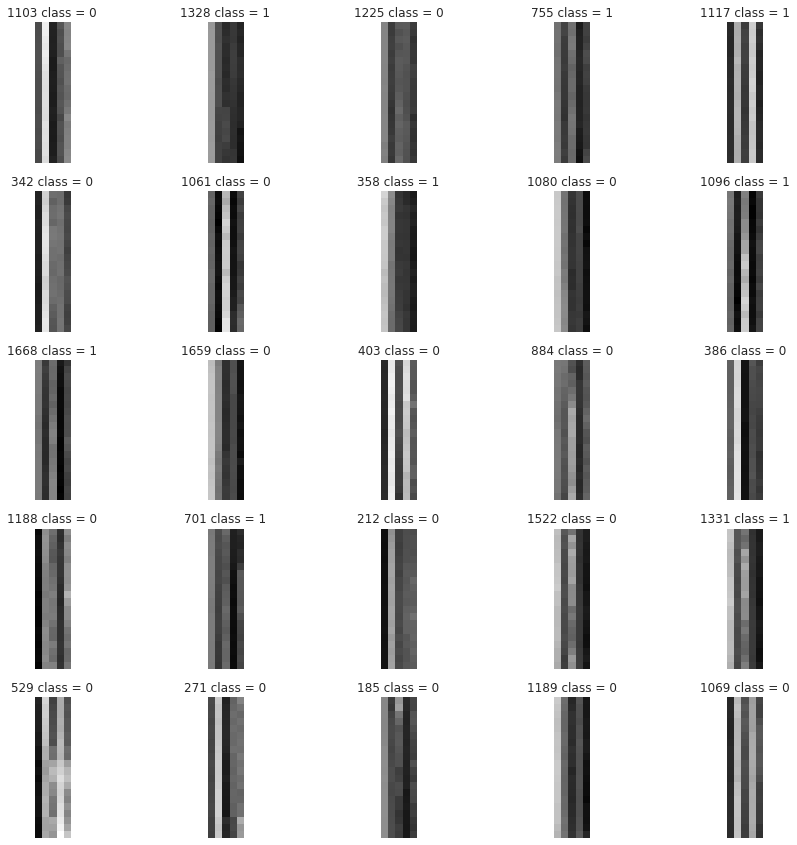

In [170]:
fig = plt.figure(figsize = (15,15))
columns = rows = 5
for i in range(1,columns*rows+1):
  index = np.random.randint(len(cnn_x_train))
  img = cnn_x_train[index]
  fig.add_subplot(rows,columns,i)
  plt.axis("off")
  plt.title(str(index)+' class = '+str(np.argmax(cnn_y_train[index])))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)
  plt.imshow(img)
plt.show()

In [ ]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

def get_model(dropout1_rate=0.25, dropout2_rate=0.5):
    model = Sequential()
    model.add(layers.Conv2D(filters=32, 
                            kernel_size=(3,3), 
                            activation='relu',
                            padding="same",
                            input_shape=input_shape))
    model.add(layers.Dropout(dropout1_rate, name="dropout_1"))
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3,3), 
                            padding="same", 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(dropout2_rate, name="dropout_2"))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dense(units=2, activation='softmax'))
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

def fit_with(dropout1_rate, dropout2_rate, lr, batchsize):

    # batchsize只能是整數，強迫把浮點轉int
    batchsize = int(batchsize)

    # 使用指定的超參數創建模型。
    model = get_model(dropout1_rate, dropout2_rate)
    
    # 設定優化器、學習率並建模
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    # 使用訓練數據集訓練模型。
    model.fit(cnn_x_train, cnn_y_train,
              batch_size = batchsize,
              epochs=250,
              verbose=0,
              validation_data=(cnn_x_test,cnn_y_test),
              callbacks=[earlystop])
    # steps=10 = 評估階段結束之前的步驟總數（樣本批次）
    # score = model.evaluate(cnn_x_test,cnn_y_test, steps=10, verbose=0)
    # 使用測試數據集評估模型。
    score = model.evaluate(cnn_x_test, cnn_y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])

    return score[1]

In [173]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
        fit_with,
        {'dropout1_rate': (0, 0.5),
        'dropout2_rate': (0, 0.5),
        'lr': (1e-5, 1e-2),
        'batchsize': (16,128)}
    )
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batchsize | dropou... | dropou... |    lr     |
-------------------------------------------------------------------------
Epoch 00025: early stopping
|  1        |  0.63     |  45.84    |  0.09901  |  0.0442   |  0.007085 |
Epoch 00101: early stopping
|  2        |  0.8565   |  69.84    |  0.04649  |  0.3386   |  0.004505 |
Epoch 00016: early stopping
|  3        |  0.6323   |  121.7    |  0.04657  |  0.143    |  0.004779 |
Epoch 00025: early stopping
|  4        |  0.6323   |  103.0    |  0.3629   |  0.257    |  0.007966 |
Epoch 00036: early stopping
|  5        |  0.5852   |  55.92    |  0.3946   |  0.3287   |  0.004467 |
Epoch 00017: early stopping
|  6        |  0.6323   |  98.27    |  0.4378   |  0.1952   |  0.008135 |
Epoch 00057: early stopping
|  7        |  0.7982   |  71.54    |  0.1482   |  0.2583   |  0.001439 |
Epoch 00069: early stopping
|  8        |  0.6883   |  67.57    |  0.2723   |  0.3373   |  0.004454 |
Epoch 00014: early stopping
|  9    

In [174]:
print(optimizer.max)
print(optimizer.max['params']['dropout1_rate'])
print(optimizer.max['params']['dropout2_rate'])
print(optimizer.max['params']['lr'])
print(optimizer.max['params']['batchsize'])
##Bayesian Optimization 找到的最佳超參數值
dropout_rate1 = optimizer.max['params']['dropout1_rate']
dropout_rate2 = optimizer.max['params']['dropout2_rate']
learning_rate = optimizer.max['params']['lr']
batchsize = int(optimizer.max['params']['batchsize'])

{'target': 0.8565022349357605, 'params': {'batchsize': 69.83645618514231, 'dropout1_rate': 0.04649325175082508, 'dropout2_rate': 0.33858267586999835, 'lr': 0.004504623725198376}}
0.04649325175082508
0.33858267586999835
0.004504623725198376
69.83645618514231


In [175]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

model = Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same",
                        input_shape=input_shape))
model.add(layers.Dropout(dropout_rate1))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        padding="same", 
                        activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(dropout_rate2))
model.add(layers.Flatten())
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=2, activation='softmax'))

adam = tensorflow.keras.optimizers.Adam(learning_rate)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

print(model.summary())

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 20, 5, 32)         896       
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 5, 32)         0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 20, 5, 64)         18496     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 10, 2, 64)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 2, 64)         0         
_________________________________________________________________
flatten_98 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_294 (Dense)            (None, 100)             

In [ ]:
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=batchsize,
                    epochs=250,
                    verbose=1,
                    validation_data=(cnn_x_test,cnn_y_test),
                    #callbacks=[earlystop],
                    )

Epoch 1/250
26/26 [==============================] - 0s 13ms/step - loss: 0.6731 - accuracy: 0.6191 - val_loss: 0.6607 - val_accuracy: 0.6323
Epoch 2/250
11/26 [===========>..................] - ETA: 0s - loss: 0.6583 - accuracy: 0.6364

In [ ]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_test,cnn_y_test)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.log(history.history['loss']), color = 'green', label='Loss')
plt.plot(np.log(history.history['val_loss']), color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='Val_accuracy')
plt.legend()
plt.title('Accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

In [ ]:
pre = model.predict_classes(cnn_x_test)
pre = pd.Series(pre)

In [ ]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_test = np.argmax(cnn_y_test, axis=1)
xcnn_y_test = pd.Series(cnn_y_test)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_test, pre)

t_size = len(cnn_y_test)
t_size1 = (cnn_y_test<1).sum()
t_guess = ((cnn_y_test<1).sum())/(len(cnn_y_test))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()

In [ ]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

t_size = len(cnn_y_validation)
t_size1 = (cnn_y_validation<1).sum()
t_guess = ((cnn_y_validation<1).sum())/(len(cnn_y_validation))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()